## Approach
* In this notebook we are trying to use Averaging techniques to form baseline models.
* We tried with classical time series forecasting but it is very time consuming.
* So here we'll be looking at the following averaging techniques
    * Simple moving average
    * Weighted moving average
    * Exponential weighted moving average
* Evaluation metrics that we have selected are root mean squared error and root mean squared log error
* We first test all our models against a grain with maximum number of non zero units.
* And then we find the best hyper-parameter (which is window size) for each grain, for all three techniques.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from functools import partial
from tqdm import tqdm

In [4]:
train_df = pd.read_csv("../csv_files/train.csv")

#### 1. Creating grain column

In [5]:
train_df['grain'] = train_df['store_nbr'].astype('str') + '_' + train_df['item_nbr'].astype('str')

#### 2. Finding the grain with maximum number of non-zero units

In [6]:
units_count_df = train_df[train_df['units']!=0].groupby(['grain'])['units'].count().reset_index()

In [7]:
max_units_grain = units_count_df[units_count_df['units'] == units_count_df['units'].max()]['grain']

In [8]:
max_units_grain

31    15_45
Name: grain, dtype: object

In [9]:
max_grain = train_df[train_df['grain'] == max_units_grain.values[0]].reset_index()

#### 3. Plotting units sold for the above grain on each day

<AxesSubplot:xlabel='date', ylabel='units'>

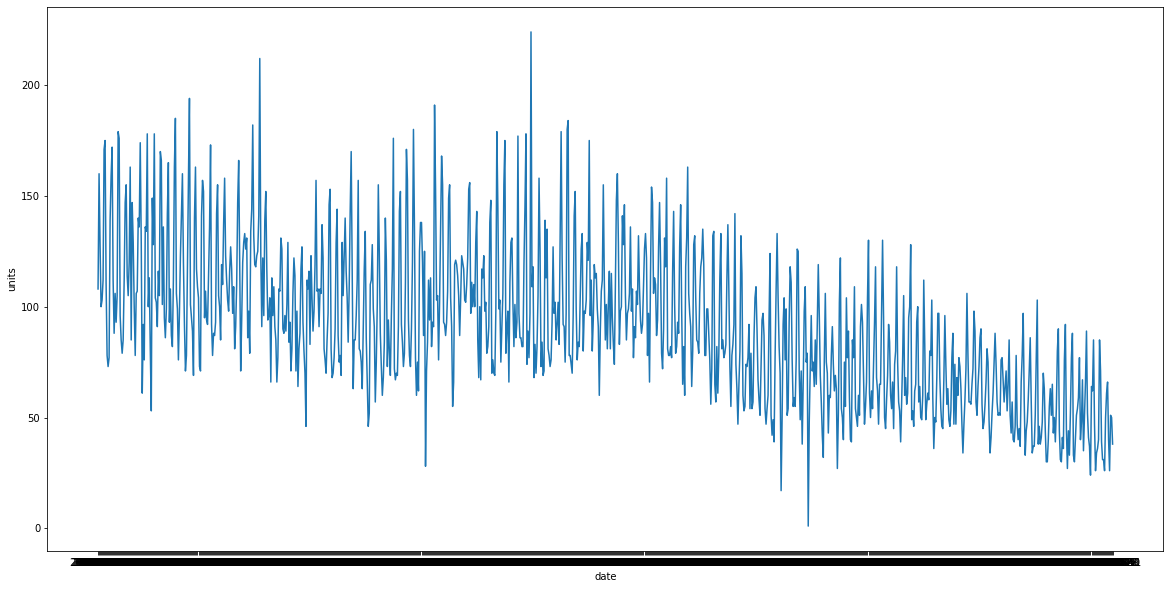

In [10]:
fig,ax1 = plt.subplots(nrows = 1,ncols = 1,figsize=(20,10))
sns.lineplot(x = "date", y = "units",data = max_grain, ax=ax1)

#### 4. Error Metric calculation

In [11]:
def calc_rmse(predictions,observations):
    return np.sqrt(mean_squared_error(observations, predictions))

In [12]:
def calc_rmsle(predictions, observations):
    total = 0 
    ## for all the predicted and actual values
    for i in range(len(predictions)):
        
        ## Take log of predicted values and add 1 to prevent underflow
        pred= np.log1p(predictions[i]+1)
        ## Take log of actual values and add 1 to prevent underflow
        targ = np.log1p(observations[i] + 1)
        
        ## if predicted and actual values are not a number then don't go 
        if not (math.isnan(pred)) and  not (math.isnan(targ)): 
            ## summation of squares of difference of logarithmic predicted and target value
            total = total + ((pred-targ) **2)
        else:
            raise Exception("predicted or actual value is not a number! | predicted : {}, target : {}".format(pred,targ))
    
    ## taking mean of the summated value
    total = total / len(predictions)        
    ## Performing square root of that value
    return np.sqrt(total)

#### 5. Plotting function to plot predictions and observations

In [13]:
def plot_observations_predictions(observations, predictions):
    plt.rc("figure", figsize=(25, 8))
    plt.rc("font", size=12)

    plt.plot(observations,color="blue",label='observations')
    plt.plot(predictions, color='red',label='predictions')
    plt.title("Plot of Predictions and Observed values")
    plt.legend(loc="upper right")
    plt.xlabel("time")
    plt.ylabel("units")
    
    plt.show()

#### 6. Evaluating Simple Moving Averages

In [14]:
def evaluate_simple_moving_average(series_data,n_steps,window_size):
    """
    series_data : total data points (100)
    n_steps : number of steps to predict in future (30)
    window_size : size of the window for averaging (3)
    
    """
    window_size = int(window_size)
    test_predictions = []
    series_len = len(series_data) ## 100
    start_index = series_len-n_steps-window_size
    end_index = series_len-n_steps
    test_obs = list(series_data[start_index:end_index]) ##series_data[100-30-3:100-30] => series_data[67:70] => series_data[67,68,69]
    
    for i in range(n_steps):
        window_avg = np.mean(test_obs[-window_size:]) ## Get the last window_size number of values and take average
        test_predictions.append(window_avg) ## Append the averaged value to test_predictions
        test_obs.append(window_avg) ## Append the same value to test_observations, this new set of values which are appended to test_obs will be used for further predictions 
        
        
    predictions = np.array(test_predictions)
    observations = np.array(series_data[end_index:])
    rmse_val = calc_rmse(predictions, observations)
    rmsle_val = calc_rmsle(predictions, observations)
    return rmse_val, rmsle_val, predictions, observations

#### 7. Evaluating Weighted Moving Averages

In [18]:
def evaluate_weighted_moving_average(series_data,n_steps, window_size):
    window_size = int(window_size)
    test_predictions = []
    series_len = len(series_data) ## 100
    start_index = series_len-n_steps-window_size
    end_index = series_len-n_steps
    test_obs = list(series_data[start_index:end_index]) ##series_data[100-30-3:100-30] => series_data[67:70] => series_data[67,68,69]
    
    for i in range(n_steps):
        win_index = 0
        window_avg = 0
        for data in test_obs[i:i+window_size]:
            window_avg += (window_size-win_index)*data
            win_index += 1
        window_avg /= (window_size*(window_size+1)/2)
        test_predictions.append(window_avg)
        test_obs.append(window_avg)

    predictions = np.array(test_predictions)
    observations = np.array(series_data[end_index:])
    rmse_val = calc_rmse(predictions, observations)
    rmsle_val = calc_rmsle(predictions, observations)
    return rmse_val, rmsle_val, predictions, observations

#### 8. Exponential Weighted Averages

In [19]:
def evaluate_exp_weighted_moving_average(series_data,n_steps, window_size):
    window_size = int(window_size)
    test_predictions = []
    series_len = len(series_data) ## 100
    start_index = series_len-n_steps-window_size
    end_index = series_len-n_steps
    test_obs = list(series_data[start_index:end_index]) ##series_data[100-30-3:100-30] => series_data[67:70] => series_data[67,68,69]
    alpha = 2/(window_size+1)
    
    for i in range(n_steps):
        win_index = 0
        ewa_num = 0
        ewa_denom = 0
        ewa_avg = 0
        for data in test_obs[i:i+window_size]:
            ewa_num += (((1 - alpha)**win_index) * data)
            ewa_denom += ((1 - alpha)**win_index)
            win_index += 1
        ewa_avg = ewa_num/ewa_denom
        test_predictions.append(ewa_avg)
        test_obs.append(ewa_avg)

            
    predictions = np.array(test_predictions)
    observations = np.array(series_data[end_index:])
    rmse_val = calc_rmse(predictions, observations)
    rmsle_val = calc_rmsle(predictions, observations)
    return rmse_val, rmsle_val, predictions, observations

#### 9. Hyper-parameter tuning for the above models and selecting the best one

In [43]:
def score_ma_models(series_data, func, hyp_param_range):
    res_df = pd.DataFrame()
    min_rmse = np.inf
    min_rmsle = np.inf
    best_param = 0
    obs = None
    best_pred = None
    start_index = hyp_param_range[0]
    end_index = hyp_param_range[1]
    window_size_int = hyp_param_range[2]
    n_steps = hyp_param_range[3]
    
    for i in tqdm(np.linspace(start_index,end_index,window_size_int)):
        rmse,rmsle,pred,obs = partial(func)(series_data,n_steps,i)
        if (rmse < min_rmse) and (rmsle < min_rmsle):
            best_param = i
            min_rmse = rmse
            min_rmsle = rmsle
            best_pred = pred
            best_obs = obs
    
    print("Best Hyper-param : ",best_param)
    print("Best RMSE : ",min_rmse)
    print("Best RMSLE : ",min_rmsle)
    plot_observations_predictions(best_obs,best_pred)
    return best_param

In [39]:
## Creating input data
series_data = max_grain['units']
series_len = len(series_data)

#### 10. Calling All the above averaging techniques along with hyper-parameter tuning and obtaining the best hyper-parameter

100%|██████████| 9/9 [00:00<00:00, 937.51it/s]


Best Hyper-param :  4.0
Best RMSE :  3.429453176315674
Best RMSLE :  0.07021289713645848


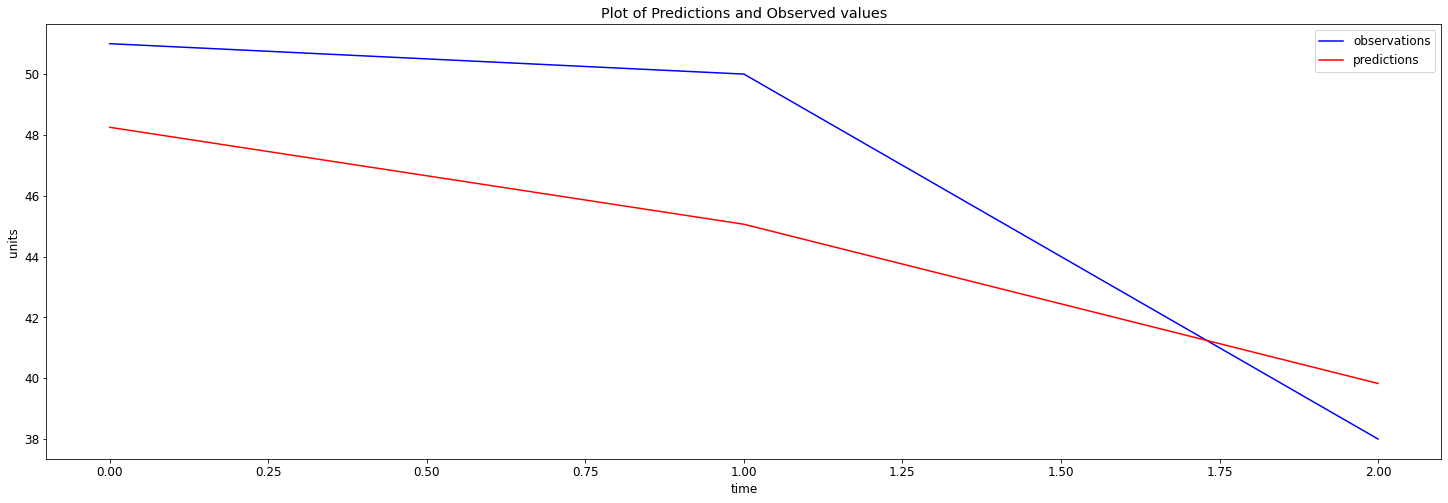

100%|██████████| 9/9 [00:00<00:00, 1963.42it/s]


Best Hyper-param :  4.0
Best RMSE :  2.4541545726923273
Best RMSLE :  0.04754816675452769


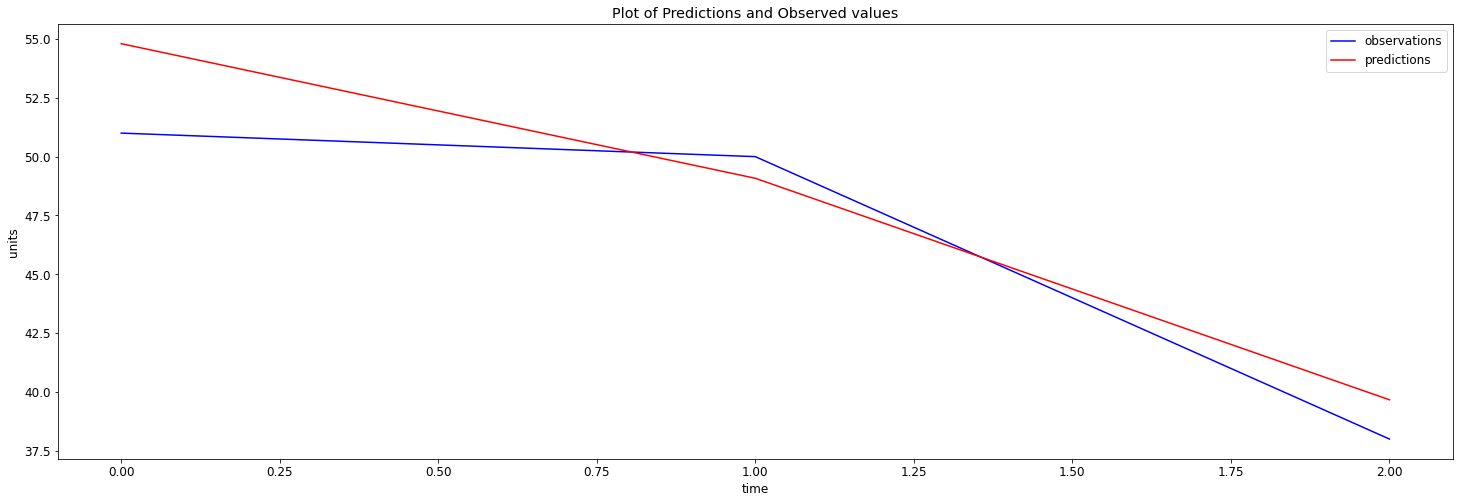

100%|██████████| 9/9 [00:00<00:00, 1991.07it/s]


Best Hyper-param :  4.0
Best RMSE :  2.8415724426891122
Best RMSLE :  0.054385935649187624


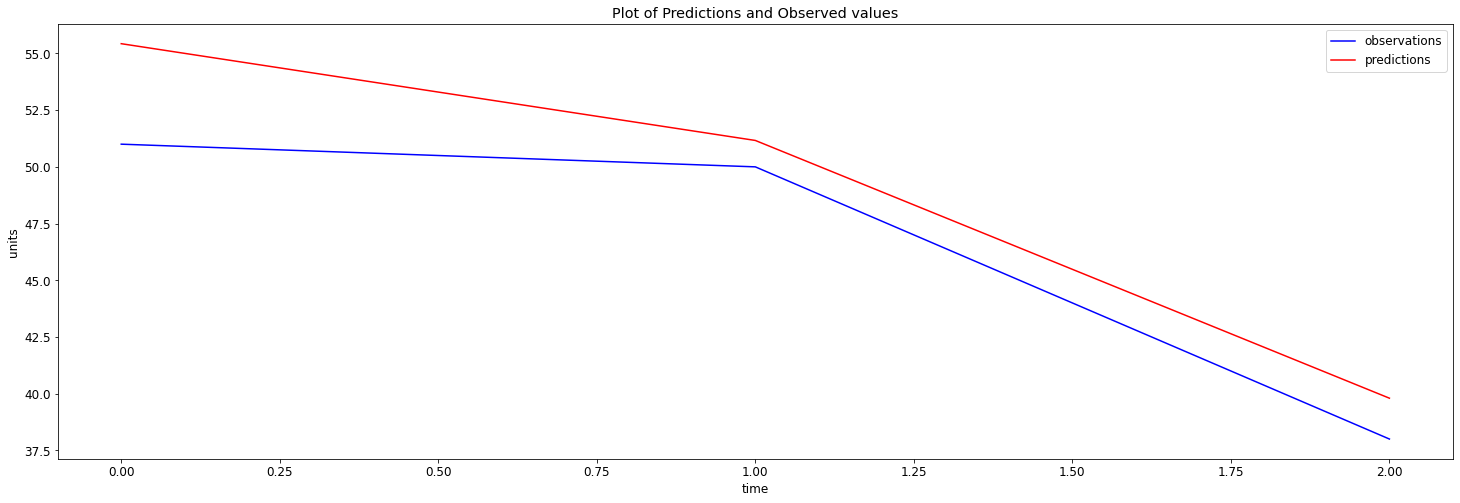

In [22]:
sma_best_param = score_ma_models(series_data, evaluate_simple_moving_average,(2,10,9,3))
wma_best_param = score_ma_models(series_data, evaluate_weighted_moving_average,(2,10,9,3))
ewma_best_param = score_ma_models(series_data, evaluate_exp_weighted_moving_average, (2,10,9,3))

* 4 turns out to be the best window size for all the above averaging techniques.
* Weighted moving average performs the best amongst the three averaging techniques.

#### 11. Let's look at the test file and see for how many steps do we have to predict for the grain that we have taken into consideration

In [25]:
test_df = pd.read_csv("../csv_files/test.csv")

In [26]:
test_df['grain'] = test_df['store_nbr'].astype('str') + '_' + test_df['item_nbr'].astype('str')

In [27]:
test_df[test_df['grain']=='15_45']

,date,store_nbr,item_nbr,grain
136241,2013-07-31,15,45,15_45
138128,2013-08-01,15,45,15_45
140015,2013-08-02,15,45,15_45
141680,2013-08-03,15,45,15_45
143012,2013-08-04,15,45,15_45
144233,2013-08-05,15,45,15_45
145787,2013-08-06,15,45,15_45
168209,2013-09-07,15,45,15_45
168986,2013-09-08,15,45,15_45
169985,2013-09-09,15,45,15_45


* By Looking at the dates we can infer that they are not continuous.
* Dates are scattered over months.
* In order to get prediction for any date we need to get the window which gave the best results on validation for each grain.
* Predict the results using past data upto it's window size.

In [28]:
units_count_df = train_df[train_df['units']!=0].groupby(['grain'])['units'].count().reset_index()

In [ ]:
hyper_param_df = pd.DataFrame()
grain_index = 0
for grain in units_count_df['grain'].values:
    series_data = train_df[train_df['grain'] == grain]['units']
    ## Storing grain information
    hyper_param_df.loc[grain_index, 'grain'] =  grain
    
    ## Storing simple moving average information
    hyper_param_df.loc[grain_index, 'sma_best_param'] = score_ma_models(series_data, evaluate_simple_moving_average,(2,10,9,3))
    
    ## Storing weighted moving average information
    hyper_param_df.loc[grain_index, 'wma_best_param'] = score_ma_models(series_data, evaluate_weighted_moving_average,(2,10,9,3))
    
    ## Storing exponential weighted moving average information
    hyper_param_df.loc[grain_index, 'ewma_best_param'] = score_ma_models(series_data, evaluate_exp_weighted_moving_average,(2,10,9,3))
    
    grain_index += 1
#hyper_param_df.head()

In [33]:
hyper_param_df.to_csv("./moving_averages_df.csv",index=False)

In [47]:
hyper_param_df

,grain,sma_best_param,wma_best_param,ewma_best_param
0,10_21,2.0,2.0,2.0
1,10_37,6.0,8.0,7.0
2,10_5,9.0,9.0,9.0
3,10_86,2.0,2.0,2.0
4,10_93,2.0,2.0,2.0
...,...,...,...,...
250,9_105,2.0,2.0,2.0
251,9_42,2.0,2.0,2.0
252,9_45,2.0,7.0,7.0
253,9_5,7.0,7.0,7.0


In [48]:
grain_df = train_df[train_df['grain'] == '9_45']

In [49]:
series_data = grain_df['units']
series_len = len(series_data)

100%|██████████| 29/29 [00:00<00:00, 1423.60it/s]


Best Hyper-param :  13.0
Best RMSE :  13.159347716899921
Best RMSLE :  0.2801114424822192


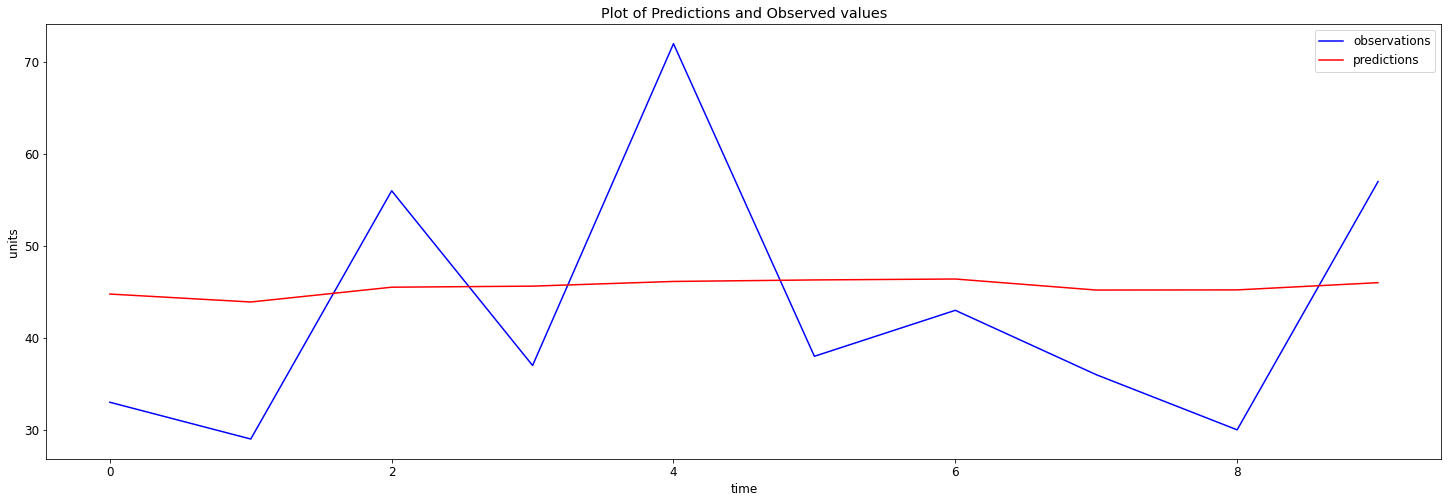

100%|██████████| 29/29 [00:00<00:00, 1925.76it/s]


Best Hyper-param :  6.0
Best RMSE :  12.426047852311589
Best RMSLE :  0.2678966293044902


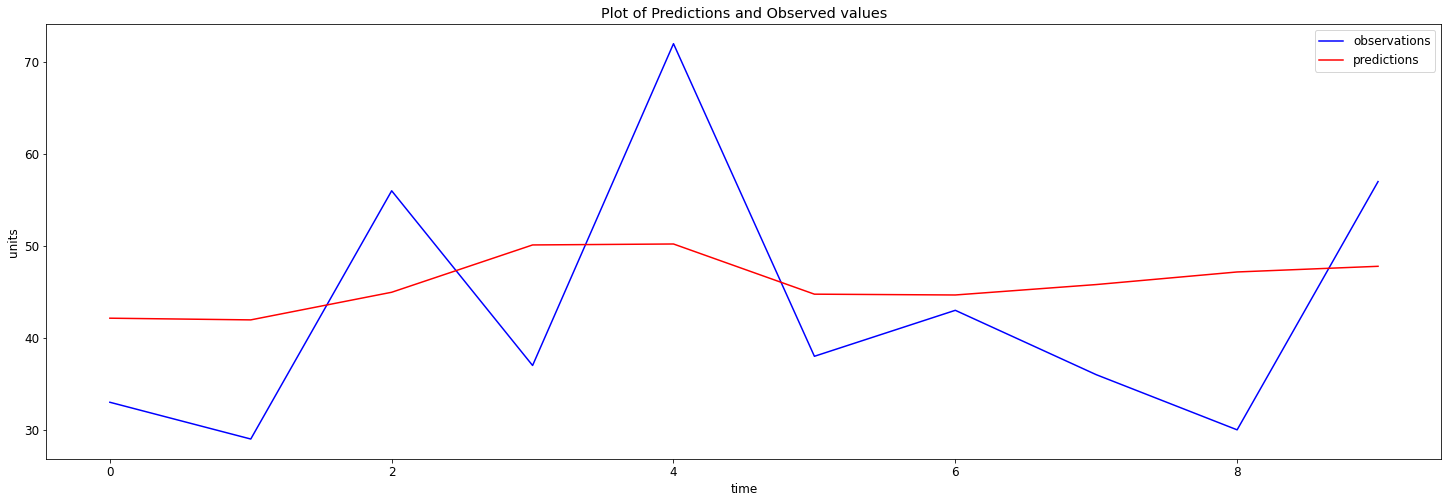

100%|██████████| 29/29 [00:00<00:00, 1282.18it/s]


Best Hyper-param :  6.0
Best RMSE :  12.13421981558204
Best RMSLE :  0.26164758265407584


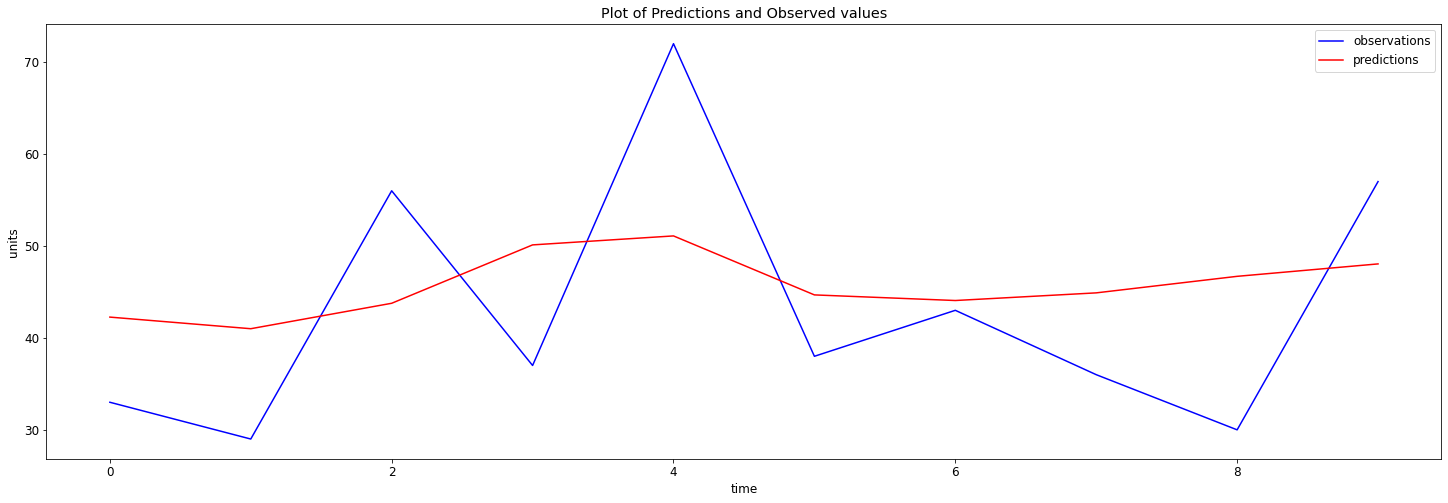

In [53]:
sma_best_param = score_ma_models(series_data, evaluate_simple_moving_average,(2,30,29,10))
wma_best_param = score_ma_models(series_data, evaluate_weighted_moving_average,(2,30,29,10))
ewma_best_param = score_ma_models(series_data, evaluate_exp_weighted_moving_average, (2,30,29,10))